In [1]:
import pandas as pd

# Load the dataset
file_path = "C:\\RAG_myhome\\Intern Prof Bala Sundaram\\equipment_anomaly_data_unprocessed.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7519 non-null   float64
 1   pressure     7519 non-null   float64
 2   vibration    7519 non-null   float64
 3   humidity     7519 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


(None,
    temperature   pressure  vibration   humidity   equipment       location  \
 0    58.180180  25.029278   0.606516  45.694907     Turbine        Atlanta   
 1    75.740712  22.954018   2.338095  41.867407  Compressor        Chicago   
 2    71.358594  27.276830   1.389198  58.954409     Turbine  San Francisco   
 3    71.616985  32.242921   1.770690  40.565138        Pump        Atlanta   
 4    66.506832  45.197471   0.345398  43.253795        Pump       New York   
 
    faulty  
 0     0.0  
 1     0.0  
 2     0.0  
 3     0.0  
 4     0.0  )

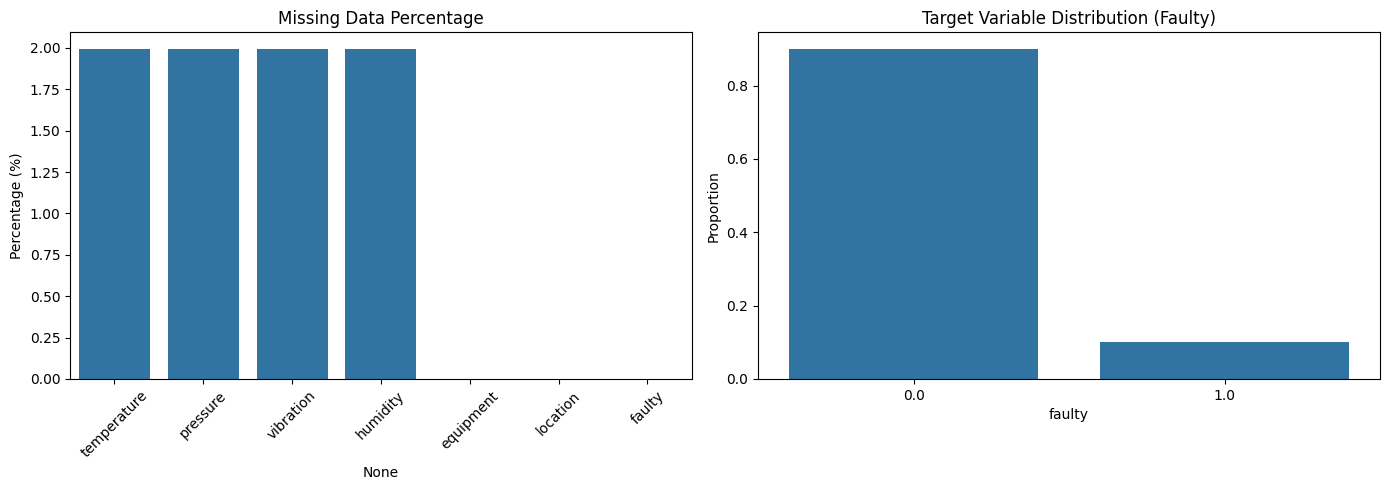

(temperature    1.994265
 pressure       1.994265
 vibration      1.994265
 humidity       1.994265
 equipment      0.000000
 location       0.000000
 faulty         0.000000
 dtype: float64,
 faulty
 0.0    0.900026
 1.0    0.099974
 Name: proportion, dtype: float64)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Handle missing values by showing percentage of missing data
missing_data_percent = df.isnull().mean() * 100

# Distribution of the target variable
faulty_distribution = df['faulty'].value_counts(normalize=True)

# Plot distributions
plt.figure(figsize=(14, 5))

# Missing data plot
plt.subplot(1, 2, 1)
sns.barplot(x=missing_data_percent.index, y=missing_data_percent.values)
plt.title("Missing Data Percentage")
plt.xticks(rotation=45)
plt.ylabel("Percentage (%)")

# Target variable distribution
plt.subplot(1, 2, 2)
sns.barplot(x=faulty_distribution.index.astype(str), y=faulty_distribution.values)
plt.title("Target Variable Distribution (Faulty)")
plt.ylabel("Proportion")

plt.tight_layout()
plt.show()

missing_data_percent,faulty_distribution

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop(columns="faulty")
y = df["faulty"].astype(int)

# Define column types
num_features = ["temperature", "pressure", "vibration", "humidity"]
cat_features = ["equipment", "location"]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Apply preprocessing and train-test split
X_processed = preprocessor.fit_transform(X)
X_processed

array([[-0.79754197, -1.03908337, -1.39902025, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30285189, -1.24080106,  1.00572977, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02825567, -0.82061863, -0.31206131, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.07027967, -0.0934504 ,  0.13213053, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.26706889, -1.16303074, -0.65463622, ...,  0.        ,
         0.        ,  0.        ],
       [-2.65938996,  3.00056784,  4.25442255, ...,  0.        ,
         0.        ,  0.        ]])

In [5]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_processed, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((11048, 12), (2762, 12), (11048,), (2762,))

In [6]:
# Define base models
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_svc = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ("rf", model_rf),
    ("gb", model_gb),
    ("svc", model_svc)
], voting="soft")

# Fit model
voting_clf.fit(X_train, y_train)

# Predict
y_pred = voting_clf.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix

({'0': {'precision': 0.9594017094017094,
   'recall': 0.980349344978166,
   'f1-score': 0.9697624190064795,
   'support': 1374.0},
  '1': {'precision': 0.9801178203240059,
   'recall': 0.9589337175792507,
   'f1-score': 0.9694100509832484,
   'support': 1388.0},
  'accuracy': 0.9695872556118754,
  'macro avg': {'precision': 0.9697597648628576,
   'recall': 0.9696415312787083,
   'f1-score': 0.969586234994864,
   'support': 2762.0},
  'weighted avg': {'precision': 0.969812267678374,
   'recall': 0.9695872556118754,
   'f1-score': 0.9695853419549788,
   'support': 2762.0}},
 array([[1347,   27],
        [  57, 1331]], dtype=int64))